In [2]:
import time

import torch
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

from sgpr.gp_regression import GP, SoR, DTC, FITC

torch.set_default_dtype(torch.float64)
%matplotlib inline

# 実験（2）

* アルゴリズム間の差を観察する


## 準備

In [3]:
class Latent_Function():
    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level
        self.noise = None

    def _f(self, X):
        # ここを好きにカスタマイズ
        tmp = np.sin(X) + np.cos(X)
        return tmp
    
    def f(self, X, observed=False):
        tmp = self._f(X)

        if observed is True:
            if isinstance(X, np.ndarray):
                noise = np.random.normal(loc=tmp, scale=self.noise_level)
                return noise
            elif isinstance(X, torch.Tensor):
                noise = torch.normal(tmp, self.noise_level)
                return noise
        
        else:
            if isinstance(X, np.ndarray):
                return np.array(tmp)
            elif isinstance(X, torch.Tensor):
                return tmp


def make_data(f, X=None, X_pred=None):
    if X is None:
        X_normal = torch.randn(50) * 1.5 + 4 
        X_normal = torch.clip(X_normal, 0, 10) 
        X_uniform = torch.rand(50) * 6 + 2  
        X_combined = torch.cat([X_normal, X_uniform])
        X, _ = torch.sort(X_combined)
        X = X.reshape(-1, 1)

    y = f(X, observed=True)

    if X_pred is None:
        X_max, X_min = X.max(), X.min()
        interval = torch.abs(X_max - X_min)
        size = int(torch.ceil(interval / 0.1))
        X_pred_max, X_pred_min = X_max + interval * 0.2, X_min - interval * 0.2
        X_pred = torch.linspace(X_pred_min, X_pred_max, size).reshape(-1, 1)

    return X, y, X_pred

GP regression
opt_iter: 1/1000
opt_iter: 2/1000
opt_iter: 3/1000
opt_iter: 4/1000
opt_iter: 5/1000
opt_iter: 6/1000
opt_iter: 7/1000
opt_iter: 8/1000
opt_iter: 9/1000
opt_iter: 10/1000
opt_iter: 11/1000
opt_iter: 12/1000
opt_iter: 13/1000
opt_iter: 14/1000
opt_iter: 15/1000
opt_iter: 16/1000
opt_iter: 17/1000
opt_iter: 18/1000
opt_iter: 19/1000
opt_iter: 20/1000
opt_iter: 21/1000
opt_iter: 22/1000
opt_iter: 23/1000
opt_iter: 24/1000
opt_iter: 25/1000
opt_iter: 26/1000
opt_iter: 27/1000
opt_iter: 28/1000
opt_iter: 29/1000
opt_iter: 30/1000
opt_iter: 31/1000
opt_iter: 32/1000
opt_iter: 33/1000
opt_iter: 34/1000
opt_iter: 35/1000
opt_iter: 36/1000
opt_iter: 37/1000
opt_iter: 38/1000
opt_iter: 39/1000
opt_iter: 40/1000
opt_iter: 41/1000
opt_iter: 42/1000
opt_iter: 43/1000
opt_iter: 44/1000
opt_iter: 45/1000
opt_iter: 46/1000
opt_iter: 47/1000
opt_iter: 48/1000
opt_iter: 49/1000
opt_iter: 50/1000
opt_iter: 51/1000
opt_iter: 52/1000
opt_iter: 53/1000
opt_iter: 54/1000
opt_iter: 55/1000
opt_i

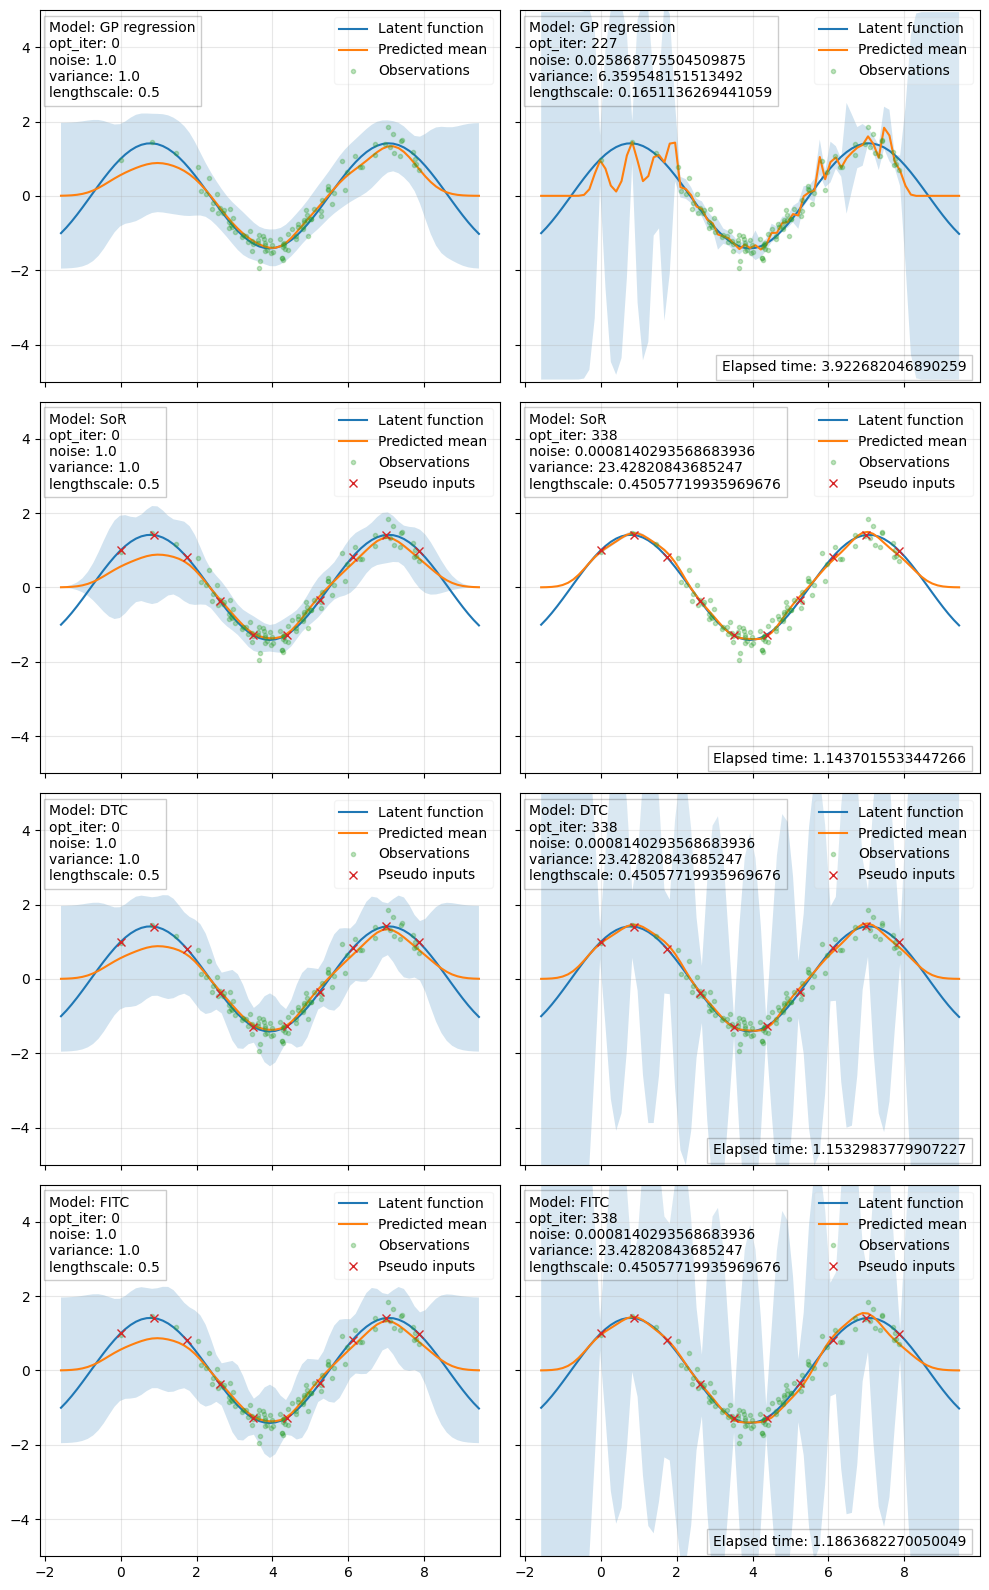

In [4]:
def add_graphs(ax, X, y, X_pred, f, model, mean, cov):
    X = X.ravel().detach().numpy()
    y = y.ravel().detach().numpy()
    X_pred = X_pred.ravel().detach().numpy()
    mean = mean.ravel().detach().numpy()
    var = torch.diagonal(cov).detach().numpy()
    credible_interval = 1.96 * np.sqrt(var) # 95%

    ax.plot(X_pred, f(X_pred), '-', label='Latent function')
    ax.plot(X_pred, mean, '-', label='Predicted mean')
    ax.fill_between(X_pred, mean - credible_interval, mean + credible_interval, alpha=0.2)
    ax.plot(X, y, 'o', alpha=0.3, ms=3, label='Observations')

    if hasattr(model, "pseudo_inputs"):
        p_inputs = model.pseudo_inputs.ravel().detach().numpy()
        ax.plot(p_inputs, f(p_inputs), 'x', alpha=1, label='Pseudo inputs')

    ax.grid(True, alpha=0.3)
    ax.set_ylim(-5, 5)
    ax.legend(fancybox=True, framealpha=0.2)

    text = f'Model: {model.name}\n' \
           f'opt_iter: {len(model.params_opt_results)}\n' \
           f'noise: {np.exp(model.params[0].item())}\n' \
           f'variance: {np.exp(model.params[1].item())}\n' \
           f'lengthscale: {np.exp(model.params[2].item())}' 
    
    ax.text(0.02, 0.97, text, 
            transform=ax.transAxes, 
            fontsize=10, 
            verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.2))


f = Latent_Function(noise_level=0.2).f
X, y, X_pred = make_data(f)
models = [GP, SoR, DTC, FITC]
# subplot_titles = ["GP regression", "SoR", "DTC", "FITC"]
include_optimize = True
nrows = len(models) 
ncols = 1

if include_optimize is True:
    ncols += 1
    # subplot_titles = [title for title in subplot_titles for _ in range(2)]
    # subplot_titles = ["Optimized " + title if i % 2 == 1 else title for i, title in enumerate(subplot_titles)]

figsize = (5 * ncols, 4 * nrows)

fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols, 
                         tight_layout=True, 
                         squeeze=False, 
                         figsize=figsize,
                         sharex=True,
                         sharey=True)

for row in range(nrows):
    X, y = X.clone(), y.clone()
    model = models[row](X, y)

    print(model.name)

    for col in range(ncols):
        mean, cov = model.predict(X_pred.clone())
        if col % 2 == 1:
            start_time = time.time()
            model.optimize(iteration=1000, learning_rate=0.01)
            mean, cov = model.predict(X_pred.clone())
            end_time = time.time()
            elapsed_time = end_time - start_time

        ax = axes[row, col]
        add_graphs(ax, X, y, X_pred, f, model, mean, cov)        
        
        if col % 2 == 1:
            ax.text(0.97, 0.02, f'Elapsed time: {elapsed_time}', 
                    transform=ax.transAxes, 
                    fontsize=10, 
                    verticalalignment='bottom', 
                    horizontalalignment='right', 
                    bbox=dict(facecolor='white', alpha=0.2))

In [52]:
# def add_subplot(fig, model, X, y, X_pred, f, mean, cov, row, col):
#     X = X.ravel().detach().numpy()
#     y = y.ravel().detach().numpy()
#     X_pred = X_pred.ravel().detach().numpy()
#     mean = mean.ravel().detach().numpy()
#     var = torch.diagonal(cov).detach().numpy()

#     row = row + 1
#     # col = col + 1

#     credible_interval = 1.96 * np.sqrt(var) # 95%

#     fig.add_trace(go.Scatter(x=X_pred, y=f(X_pred), line_color="#00CC00", name="Latent Function", showlegend=False), 
#                   row=row, col=col)
#     fig.add_trace(go.Scatter(x=X_pred, y=mean, line_color="#FE73FF", name="Mean", showlegend=False), 
#                   row=row, col=col)
#     fig.add_trace(go.Scatter(x=X_pred, y=mean-credible_interval, mode='lines', line=dict(color='lightgray'), showlegend=False), 
#                   row=row, col=col)
#     fig.add_trace(go.Scatter(x=X_pred, y=mean+credible_interval, mode='lines', line=dict(color='lightgray'), fill='tonexty', showlegend=False), 
#                   row=row, col=col)
#     fig.add_trace(go.Scatter(x=X, y=y, mode='markers', marker=dict(size=4, color="#0000FF", opacity=0.3), name="Observations", showlegend=False), 
#                   row=row, col=col)
#     fig.update_xaxes(title_text="x", row=row, col=col)
#     fig.update_yaxes(title_text="f*", row=row, col=col)
    
#     if hasattr(model, "pseudo_inputs"):
#         p_inputs = model.pseudo_inputs.ravel().detach().numpy()
#         fig.add_trace(go.Scatter(x=p_inputs, y=f(p_inputs), mode='markers', marker=dict(size=6, color="#FF0000", opacity=1), name="Pseudo-inputs", showlegend=False), 
#                       row=row, col=col)

# f = Latent_Function(noise_level=0.2).f
# X, y, X_pred = make_data(f)
# models = [GP, SoR, DTC, FITC]
# include_optimize = True
# rows = len(models)
# cols = 1
# subplot_titles = ["GP regression", "SoR", "DTC", "FITC"]


# if include_optimize is True:
#     cols +=1
#     subplot_titles = ["GP regression", "SoR", "DTC", "FITC"]
#     subplot_titles = [title for title in subplot_titles for _ in range(2)]
#     subplot_titles = ["Optimized " + title if i % 2 == 1 else title for i, title in enumerate(subplot_titles)]


# fig = make_subplots(rows=rows, cols=cols, 
#                     # shared_xaxes=True,
#                     # shared_yaxes=True,
#                     vertical_spacing=0.08,
#                     subplot_titles=subplot_titles)

# for row, m in enumerate(models):
#     col = 1
#     model = m(X, y)
#     mean, cov = model.predict(X_pred.clone())
#     add_subplot(fig, model, X, y, X_pred, f, mean, cov, row, col)

#     if include_optimize is True:
#         col = 2
#         model.optimize(iteration=100, learning_rate=0.01)
#         mean, cov = model.predict(X_pred.clone())
#         add_subplot(fig, model, X, y, X_pred, f, mean, cov, row, col)

# fig.add_trace(go.Scatter(x=[None], y=[None], line_color="#00CC00", name="Latent Function"))
# fig.add_trace(go.Scatter(x=[None], y=[None], line_color="#FE73FF", name="Mean"))
# fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=6, color="#FF0000", opacity=1), name="Pseudo-inputs"))
# fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=4, color="#0000FF", opacity=0.3), name="Observations"))
    
# fig.update_layout(title="GP Regressions Visualization", height=1300, width=900)
# fig.show()
